# Семинар 10: Классификация

В прошлый раз мы говорили про регрессию: мы пытались по выборке предсказать значение непрерывной переменной, количество лайков под постом. В этот раз мы поговорим про задачу классификации. __Вы же ещё не забыли чем отличаются друг от друга эти задачи?__ 

In [22]:
import pandas as pd               # уже знакомый вам пакет для работы с таблицами
import numpy as np                # смутно знакомый вам пакет для работы с матрицами

import matplotlib.pyplot as plt   # уже смутно знакомый вам пакет для картинок :3
import matplotlib
import seaborn as sns             # ещё один пакет для картинок 
plt.style.use('ggplot')           # правильный (очень красивый) стиль у графиков

%matplotlib inline

# 1. Данные и пропуски 

На одном из предыдущих семинаров мы строили с вами визуализации для клипов с youtube. Сегодня мы продолжим с ним работать и попробуем предсказывать жарн видео по его параметрам. 

In [23]:
pwd

'/Users/randomwalk/Downloads/solutions_2020/sem_solutions'

In [24]:
data = pd.read_csv('../../youtube_data.csv', sep = '\t')
data.head()

,title,caption,categoryId,commentCount,definition,description,dislikeCount,duration,license,licensedContent,...,comment_mean_len_symbol,comment_mean_len_word,comment_negative_mean_prob,comment_negative_share,commentators_uniq,comments_emoji_max,comments_emoji_mean,comments_emoji_share,comments_obscene_cnt,words_obscene_cnt
0,"""#2Маши ""Свободные линии""",False,10,34.0,hd,ITUNES - https://itun.es/ru/0YzI_,43.0,PT3M30S,youtube,True,...,59.440000,8.840000,0.635410,0.480000,24.0,9.0,1.000000,0.320000,0.0,0.0
1,"""ALARM"" СЕРГЕЙ ЛАЗАРЕВ ( SERGEY LAZAREV )",False,10,NaN,sd,NEW OFFICIAL VIDEO\r\n2010,690.0,PT3M42S,youtube,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"""EARTH SONG"" SERGEY LAZAREV. DEDICATED TO MIC...",False,10,26.0,sd,Посвящается Майклу Джексону...\r\nCover-versio...,10.0,PT5M46S,youtube,False,...,120.000000,19.291667,0.725987,0.750000,23.0,13.0,0.666667,0.125000,0.0,0.0
3,"""Earth song"" премия МУЗ-тВ 2010 (LIVE)",False,10,12.0,sd,"Сергей Лазарев, La Toya Jackson, Ани Лорак, Т...",7.0,PT6M16S,youtube,False,...,81.818182,11.545455,0.736776,0.727273,11.0,13.0,1.181818,0.090909,0.0,0.0
4,"""FAKE"" СЕРГЕЙ ЛАЗАРЕВ (SERGEY)",False,10,46.0,sd,official video,19.0,PT3M,youtube,True,...,43.735294,8.617647,0.596008,0.441176,33.0,23.0,0.794118,0.088235,1.0,1.0


In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19124 entries, 0 to 19123
Data columns (total 30 columns):
title                         19124 non-null object
caption                       19124 non-null bool
categoryId                    19124 non-null int64
commentCount                  18914 non-null float64
definition                    19124 non-null object
description                   18339 non-null object
dislikeCount                  18850 non-null float64
duration                      19124 non-null object
license                       19124 non-null object
licensedContent               19124 non-null bool
likeCount                     18850 non-null float64
music_style                   19124 non-null object
performer                     19124 non-null object
publicStatsViewable           19124 non-null bool
publishedAt                   19124 non-null object
tags                          17806 non-null object
video_id                      19124 non-null object
viewCount  

Можно заметить, что некоторые данные у нас отсутствуют. Давайте посмотрим на заполненность нашей таблички на картинке. 

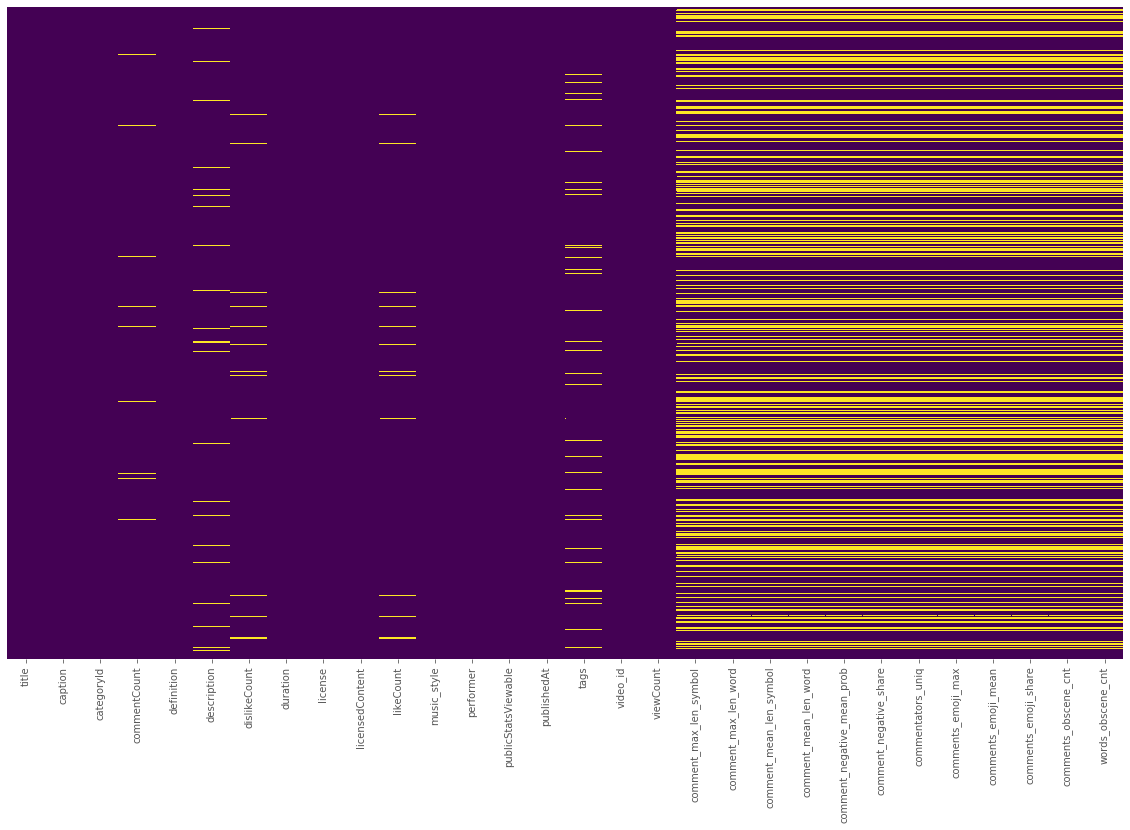

In [26]:
fig, ax = plt.subplots(figsize=(20,12))
sns_heatmap = sns.heatmap(data.sample(1000).isnull(), yticklabels=False, cbar=False, cmap='viridis')

Что мы говорим пропускам в данных? Не сегодня. С пропусками нужно бороться. Алгоритмы оцениваются на числах и не любят пропуски (некоторые настроены к пропускам нейтрально, так как умеют их обрабатывать). 

Первое решение: выбросить все наблюдения с пропусками. Проблема такого подхода в том, что другие то переменные для этих наблюдений не пропущены. Значит, выбросив строчки, соответствующие пропускам, мы потеряем кучу информации. Полезной информации. Информацию и без всех наших преобразований легко потерять, сложно найти и невозможно забыть, а мы её ещё и выкинуть хотим. 

Обычно, если пропусков в переменной не очень много, их заполняют чем-нибудь нейтральным. Например, средними или медианами. Когда алгоритм будет натыкаться на них, он будет думать: "Хммм, ну тут ничего особенного, всё как в среднем по выборке, пойду посмотрю другую переменную". И тогда всё будет хорошо. 

Для удобства создаём список из непрерывных переменных. Дальше будем работать только с ними.

In [27]:
real_variables = ["commentCount",              # число комментов под видосом
                  "dislikeCount",              # число дисолайков 
                  "likeCount",                 # лайки 
                  "viewCount",                 # просмотры 
                  "comment_max_len_symbol",    # максимальная длинна комента 
                  "comment_max_len_word",      # максимальное число слов в коменте 
                  "comment_mean_len_symbol",   # средняя длина комента
                  "comment_mean_len_word",     # среднее число слов в коменте 
                  "comment_negative_share",    # средяя доля негатива в коментах 
                  "comment_negative_mean_prob",# ещё одна переменная, отвечающая за негатив
                  "commentators_uniq",         # число уникальных коментаторов 
                  "comments_emoji_max",        # максимальное число эмодзи в коменте
                  "comments_emoji_mean",       # среднее число эмодзи 
                  "comments_emoji_share",      # доля коментов с эмодзи 
                  "comments_obscene_cnt",      # число матерных коментов 
                  "words_obscene_cnt"          # число матерных слов под видосом
                 ]

Давайте заполним во всех непрерывных переменных пропуски средними. 

In [28]:
for column in real_variables:
    data[column] = data[column].fillna(data[column].mean())

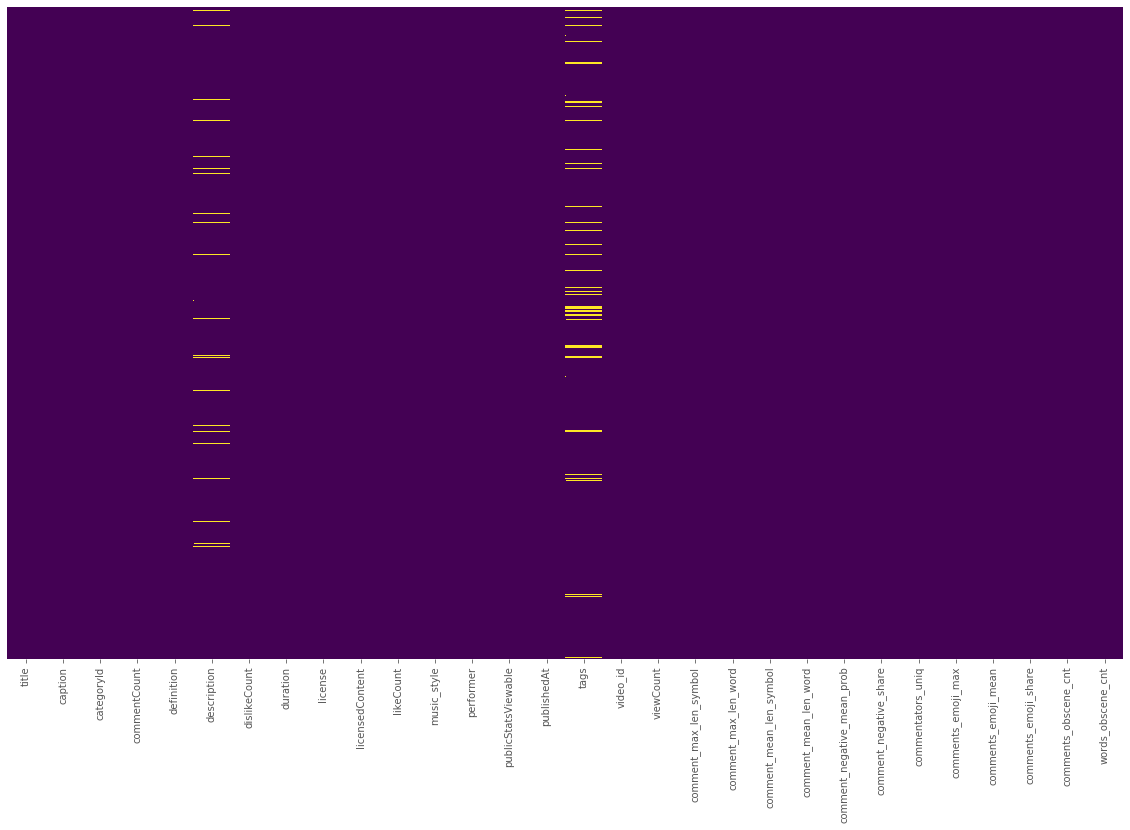

In [29]:
fig, ax = plt.subplots(figsize=(20,12))
sns_heatmap = sns.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap='viridis')

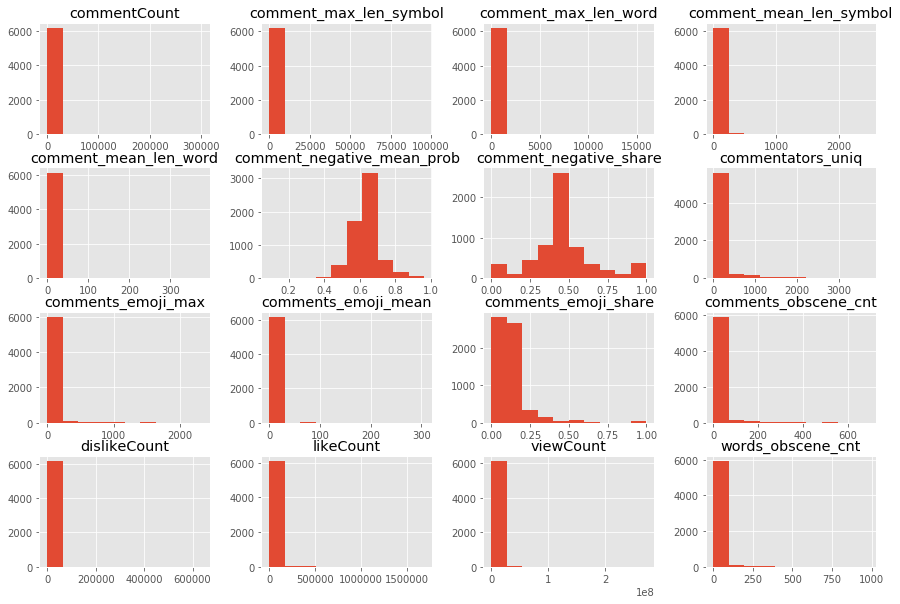

In [72]:
# надо бы побороться с выбросами
data[real_variables].hist(figsize=(15,10));

In [73]:
data[real_variables] = data[real_variables].apply(lambda w: np.log(w + 1))

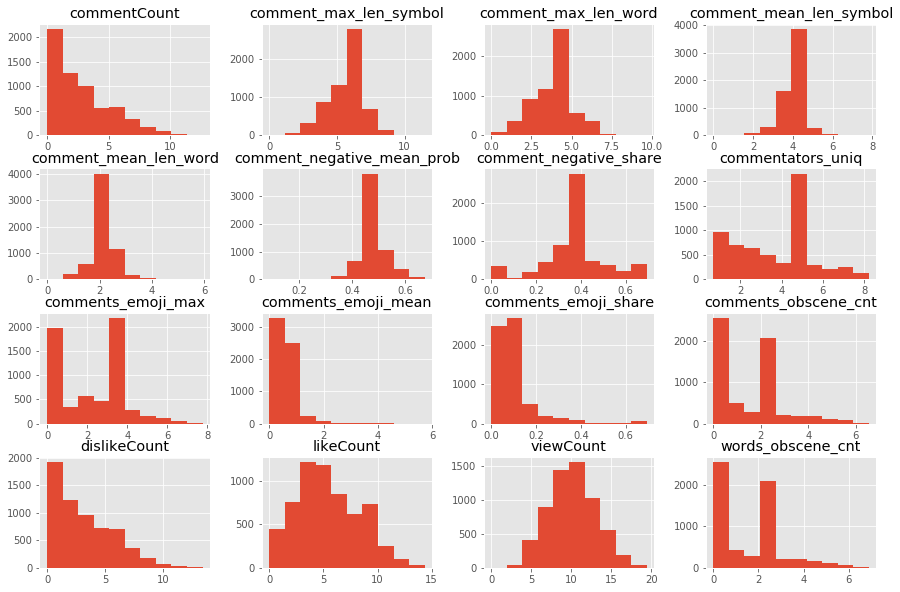

In [74]:
data[real_variables].hist(figsize=(15,10));

# 2. Что будем предсказывать? 

Предсказывать будем жанр видео. Давайте посмотрим какие у нас есть жанры в данных. 

In [75]:
data.music_style.value_counts()

estrada    4151
rap        2028
Name: music_style, dtype: int64

Давайте для простоты оставим в данных только два жанра. Например, рэпчик и эстраду (Киркоров и компания). Попробуем заставить машины разбираться что за видос перед ними. 

In [76]:
data = data[(data.music_style == 'estrada') | (data.music_style == 'rap')]

Разбиваем выборку на обучающую, в которой мы будем находить закономерности, и тестовую выборку, на которой мы будем проверять выявленные закономерности.

In [77]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size = 0.2, random_state=201905, stratify=data['music_style'])

print("Размер обучающей выборки:", train.shape)
print("Размер тестовой выборки:", test.shape)

Размер обучающей выборки: (4943, 30)
Размер тестовой выборки: (1236, 30)


Убедимся, что мы не нарушили пропорции жанров при делении выборки на тренировочную и тестову. __Как думаете, зачем это нужно?__ 

In [78]:
train.music_style.value_counts()/train.shape[0]

estrada    0.671859
rap        0.328141
Name: music_style, dtype: float64

In [79]:
test.music_style.value_counts()/test.shape[0]

estrada    0.671521
rap        0.328479
Name: music_style, dtype: float64

Вроде бы всё нормально. Сейчас в нашем датасете все жанры записаны в текстовом виде. Мы с вами постоянно повторяем, как прописную истину то, что __модели поедают только цифры.__ Давайте переработаем жанры в дамми-переменную. Будем обозначать рэпчик за $1$, попсу за $0$. 

In [80]:
y_train = 1 * (train.music_style.to_numpy() == 'rap')
y_train

array([1, 1, 1, ..., 1, 0, 0])

In [81]:
y_test = 1 * (test.music_style.to_numpy() == 'rap')
y_test

array([0, 0, 0, ..., 1, 0, 0])

# 3. Моделирование! 

Давайте строить прогнозные модели! 

## 3.1 k Nearest Neighbours (метод ближайших соседей) 

**KNN** - один из базовых и максимально наглядных алгоритмов. Среди уже известных нам объектов находятся $k$ максимально похожих на наш неизвестный объект (соседей). Неизвестному объекту проставляется тот класс, который наиболее широко представлен среди его соседей. 

Возьмем все числовые данные из нашего набора.

In [82]:
X_train = train[real_variables].to_numpy()
X_test = test[real_variables].to_numpy()

Внутри метода ближайшего соседа мы будем измерять похожесть между объектами с помощью какого-то расстояния. На примеры таких расстояний мы смотрели на паре по математике для анализа данных. 

Давайте посмотрим на слудущую проблему. Пусть у нас есть два человека: Вася и Петя. Вася весит $90$ кг. Петя $60$ кг. У Васи рост $1.9$ метра. У Пети $1.7$ метра. Посчитаем расстояние между парнями: 

$$
\rho(\text{Вася}, \text{Петя}) = \sqrt{(1.9 - 1.7)^2 + (90 - 60)^2} = \sqrt{0.04 + 900}. 
$$

Какой из признаков вносит больший вклад в расстояние? Вес. Просто из-за того, что он измерен в другой шкале. Это будет путать алгоритм, когда он будет искать расстояния. Чтобы избежать такой путанницы, данные нужно отскалировать. То есть привести к одной шкале. Например, с помощью `Min-max scaler`, который вы сами реализовывали в третьей домашке. После такого скалирования мы избавимся от зависимости от шкалы измерения. 

In [83]:
from sklearn.preprocessing import MinMaxScaler  # класс для скалирования! 

# Объеявили скалировшик 
scaler = MinMaxScaler( )

# Он сам будет считать максимумы, минимумы и делить! 
# (x - min)/(max - min) => [0; 1]

# Обучили его на тренировочной выборке (он само посчитал все максимумы, минимумы)
scaler.fit(X_train) 

# Теперь применяем его к нашим данным, скалировщик сам применяем формулу (x - min)/(max - min)
X_train_norm = scaler.transform(X_train) 
X_test_norm = scaler.transform(X_test)

In [84]:
X_train_norm.max()

1.0

In [85]:
X_test_norm.max()

1.0263664955453236

Наконец-то мы можем начать учить модели. Подгружаем метод ближайших соседей из пакета. 

In [86]:
from sklearn.neighbors import KNeighborsClassifier

# объявляем метод 9 ближайших соседей
knn = KNeighborsClassifier(n_neighbors = 9)

# обучаем его по тренировочные выборке 
knn.fit(X_train_norm, y_train)

# строим для тестовой выборки прогнозы 
y_pred_knn = knn.predict(X_test_norm)

# прогнозы вероятностей
p_pred_knn = knn.predict_proba(X_test_norm) 
p_pred_knn = p_pred_knn[:, 1]  # P(y = 1 | X)

Взглянем на прогнозы. 

In [87]:
y_pred_knn

array([0, 0, 0, ..., 1, 1, 0])

In [88]:
p_pred_knn

array([0.        , 0.11111111, 0.        , ..., 1.        , 0.77777778,
       0.        ])

Интересно было бы узнать насколько качественной у нас получилась модель. Давайте посмотрим на какую-нибудь метрику качества, например на `accuracy`.  __Как думаете, это хорошая идея?__ 

In [58]:
from sklearn.metrics import accuracy_score

# считаем долю верно построенных прогнозов 
accuracy_score(y_test, y_pred_knn)

0.7766990291262136

In [70]:
# Проскалировали данные => качество сильно выросло 
accuracy_score(y_test, y_pred_knn)

0.8446601941747572

In [89]:
# Сгладили выбросы => качество подскочило ещё сильнее
accuracy_score(y_test, y_pred_knn)

0.8762135922330098

Давайте попробуем посчитать ещё и другую метрику. Например, площадь под roc-кривой. 

In [59]:
from sklearn.metrics import roc_auc_score

# считаем долю верно построенных прогнозов 
roc_auc_score(y_test, p_pred_knn)

0.7318179120422577

In [71]:
# Проскалировали данные => качество сильно выросло 
roc_auc_score(y_test, p_pred_knn)

0.8075850198824858

In [112]:
# Сгладили выбросы => качество подскочило ещё сильнее
roc_auc_score(y_test, p_pred_knn)

0.9362543771143689

Окей. Хотим улучшить качество. Возможно нам стоит попробовать по разному учитывать соседей: более близкие соседи должны давать больший вклад, чем удаленные. Для этого у метода есть опция `distance`. 

In [97]:
# снова объявили метод ближайших соседей
knn = KNeighborsClassifier(n_neighbors = 9, weights='distance')

# обучили его 
knn.fit(X_train_norm, y_train)

# строим для тестовой выборки прогнозы 
y_pred_knn = knn.predict(X_test_norm)

# прогнозы вероятностей
p_pred_knn = knn.predict_proba(X_test_norm) 
p_pred_knn = p_pred_knn[:, 1]  # P(y = 1 | X)

# посчитали долю верных ответов
print('accuracy:', accuracy_score(y_test, y_pred_knn))
print('roc_auc:', roc_auc_score(y_test, p_pred_knn))

accuracy: 0.8794498381877023
roc_auc: 0.9362543771143689


Чуточку лучше. Для того, чтобы построить хорошую модель иногда нужно перебрать довольно много разных параметров модели. Давайте попробуем немного поперибирать. 

In [93]:
# Решётка для перебора 
from sklearn.model_selection import GridSearchCV

# параметры, которые мы будем перебирать 
parameters = {
     'n_neighbors':range(5, 16),         # число соседей от 5 до 15
     'weights':['uniform', 'distance']   # надо ли более близких соседей учитывать с большим весом
             }

# объявили модель
knn_clf = KNeighborsClassifier()

# завернули её в решётку для поиска параметров
grid_knn = GridSearchCV(knn_clf, parameters, cv=5, scoring="roc_auc")

# Обратите внимание на аргументы решчетого поиска: 
#       1. Сначала модель
#       2. Какие параметры перебирать 
#       3. Число фолдов для кросс-валидации (подробнее с ней вы поработаете в домашке)
#       4. Метрика, по которой нужно считать качество модели (можно указать accuracy и любую другую)

# обучаем нашу решётку (если мы хотим перебрать много параметров, обучение будет идти долго) 
grid_knn.fit(X_train_norm, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'n_neighbors': range(5, 16),
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [94]:
# смотрим какие параметры дали наибольшее качество
print(grid_knn.best_estimator_)

# а также смотрим на качество этого классификатора
print(grid_knn.best_score_)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                     weights='distance')
0.945746520732018


А вот такое улучшение качества уже повесомее, $15$ соседей и алгоритм, учитывающий разные расстояния. 

__Задание (если в конце пары будет время):__  Попробуйте улучшить качество модели ещё сильнее.

In [24]:
# ваш код 

## 3.2 Решающие деревья 

<img src = "http://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1528907338/classification-tree_ygvats.png">

В листьях дерево - конечные принимаемые решения, в разветвлениях функции от отдельного признака. Давайте посмотрим как обучить дерево в питоне. 

In [96]:
# Подшружаем дерево 
from sklearn.tree import DecisionTreeClassifier

# Объявляем дерево 
tree = DecisionTreeClassifier( )

# учим дерево 
tree.fit(X_train_norm, y_train)

# предсказываем на тестовой выборке результаты 
y_pred_tree = tree.predict(X_test_norm)

# предсказываем вероятности
p_pred_tree = tree.predict_proba(X_test_norm) 
p_pred_tree = p_pred_tree[:, 1]  # P(y = 1 | X)

# посчитали долю верных ответов
print('accuracy:', accuracy_score(y_test, y_pred_tree))
print('roc_auc:', roc_auc_score(y_test, p_pred_tree))

accuracy: 0.8551779935275081
roc_auc: 0.8368063386551132


Дерево хорошо своей простотой, но по факту, чем выше наше дерево, тем более оно склонно к переобучению.
Как быть? Построить много невысоких деревьев. Много деревьев - это лес, алгоритм, принимающий решение на основе множества деревьев, так и называется.


In [98]:
# Подшружаем случайный лес
from sklearn.ensemble import RandomForestClassifier

# объявляем его, будем учить 1000 деревьев
forest = RandomForestClassifier(n_estimators=1000)

# учим лес 
forest.fit(X_train_norm, y_train)

# строим предсказания 
y_pred_forest = forest.predict(X_test_norm)

# предсказываем вероятности
p_pred_forest = forest.predict_proba(X_test_norm) 
p_pred_forest = p_pred_forest[:, 1]  # P(y = 1 | X)

# посчитали долю верных ответов
print('accuracy:', accuracy_score(y_test, y_pred_forest))
print('roc_auc:', roc_auc_score(y_test, y_pred_forest))

accuracy: 0.9029126213592233
roc_auc: 0.8811561517003976


In [118]:
forest.predict_proba(X_test_norm)  # [ P(y = 0 | X), P(y = 1 | X) ]

array([[1.   , 0.   ],
       [0.984, 0.016],
       [1.   , 0.   ],
       ...,
       [0.009, 0.991],
       [0.398, 0.602],
       [0.999, 0.001]])

Качество получше, чем у отдельного дерева. Близкое к методу ближайших соседей. 

# 4. Метрики классификации 

Только что мы построили два алгоритма и построили для них разные метрики. Давайте попробуем посравнивать их между собой с помощью оставшихся метрик классификации. 

Разные метрики качества мы с вами разобрали на доске. Если вы не поняли их, можно [глянуть лекцию Жени Соколова.](https://www.coursera.org/learn/vvedenie-mashinnoe-obuchenie/lecture/IVuAc/mietriki-kachiestva-klassifikatsii-1)  Расскажите потом понятной она вам показалась или непонятной, если будете смотреть.

Вкратце напомню о чём шла речь. Предсказывая отток, мы можем совершить ошибки двух видов: 

* Ошибка первого рода: мы предсказали человеку, что он уйдёт, а он остался.
* Ошибка второго рода: мы предсказали, что человек останется, а он ушёл.

В разных задачах критичны разные виды ошибок. На основе этих ошибок можно придумать много метрик. Мы с вами построили вот такую табличку  

![](http://blog.exsilio.com/wp-content/uploads/2016/09/table-blog.png)

и обсудили слудущие метрики качества: 

* Доля верно классифицированных объектов:

$$Accuracy = \frac{TP + TN}{TP + FP + TN + FN}$$

Интуитивно понятная, очевидная и почти неиспользуемая метрика. Её главная проблема в том, что она бесполезна в задачах с неравными классами. Например, пусть у нас есть $50$ больных и $950$ здоровых. Мы хотим научиться их различать. Пусть наш алгоритм предсказывает, что все здоровы. В этом случае доля правильных ответов составит $95\%$, но алгорим окажется абсолютно бесполезным. 

Чтобы избежать таких эксцессов, а также учитывать, что разные типы ошибок могут иметь разную цену, строят другие две метрики: точность и полноту. 

* Точность (precision): 

$$P = \frac{TP}{TP + FP}$$

Отражает то, насколько мы можем доверять алгоритму, если он спрогнозировал единичку. 

* Полнота (Recall): 

$$R = \frac{TP}{TP + FN}$$

Показывает, как много объектов первого класса наш алгоритм находит.

Введение `Precision` не позволяет нам записывать все объекты в один класс, так как в этом случае мы получаем рост уровня `False Positive`. `Recall` демонстрирует способность алгоритма обнаруживать данный класс вообще, а `Precision` — способность отличать этот класс от других классов.

Более высокая точность влечёт более низкую полноту. Баланс между этими характеристиками выбирается в зависимости от задачи. В случае поиска больных, на бы хотелось получить максимальную полноту. Нестрашно, если здоровый сдаст анализы, страшно если мы пропустим больного. В задаче выдаче кредитов, наоборот, важнее точность.

Можно склеить эти две метрики, посчитав их среднее гармонческое и получить f-меру: 

* F-measure: 

$$F = \frac{\beta \cdot precision \cdot recall}{precision + recall}$$

Параметр $\beta$ в данном случае определяет вес точности в метрике. $\beta = 1$ вносит точность и полноту с одинаковыми весами. Изменяя его, можно отдавать предпочтения либо одному либо другому. 

Все эти метрики уже есть в пакете sklearn. По уму надо бы реализовать их самостоятельно, чтобы лучше понять, но у нас на это нет особо времени, поэтому это домашнее задание :) 

Итак, посмотрим на наши чудо-метрики! Для начала подгрузим их. 

In [99]:
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve
from sklearn.metrics import roc_auc_score, roc_curve, auc

__Внимание!__ В ячейке ниже будет несколько страшных функций для красивых картинок. Вы не обязаны разбираться в том, как они устроены. Но вот понимать что эти картинки обозначают и как метрики классификации работают, вы обязаны. 

In [100]:
import itertools

# Функция для отрисовки roc-auc кривой    
def roc_auc_pic(y_hat_test, y_test):    
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_hat_test)
    roc_auc_test = roc_auc_score(y_test, y_hat_test)

    matplotlib.rcParams['figure.figsize'] = (8, 8)
    plt.plot(fpr_test, tpr_test, label='Test ROC AUC {0}'.format(roc_auc_test))
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show() 
    pass


# Картинки для PR-кривой, а-меры и прочих ништяков
def plot_precision_recall_curve(y_pred_proba, y_test):
    plt.figure(figsize=(10, 10))
    f_scores = np.linspace(0.4, 0.9, num=6)
    lines = []
    labels = []
    
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
        plt.annotate('f1={0:0.2f}'.format(f_score), xy=(0.9, y[45] + 0.02))
        
    precision, recall, _ =  precision_recall_curve(y_test, y_pred_proba)

    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                     color='b')
    plt.xlabel('Recall', size=15)
    plt.ylabel('Precision', size=15)
    plt.title('Precision-Recall curve', size=18)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.show()

__Внимание!__ Страшный кодище для картинок закончился. Начиная с этой строки, нужно снова начать понимать. У нас есть три функции: 

* `plot_confusion_matrix` строит матрицу ошибок
* `roc_auc_pic` строит рок-кривую
* `plot_precision_recall_curve` строит кривую точнось-полнота

Начнём с моделей. Будем смотреть на две: случайный лес и ближайшие соседи. 

In [102]:
# Начнёмс с того, что построим прогнозы 
p_pred_forest = forest.predict_proba(X_test_norm)[:,-1]
p_pred_knn = knn.predict_proba(X_test_norm)[:,-1]

Для каждой построим картинки и сравним их между собой. Начнём с roc-кривых. 

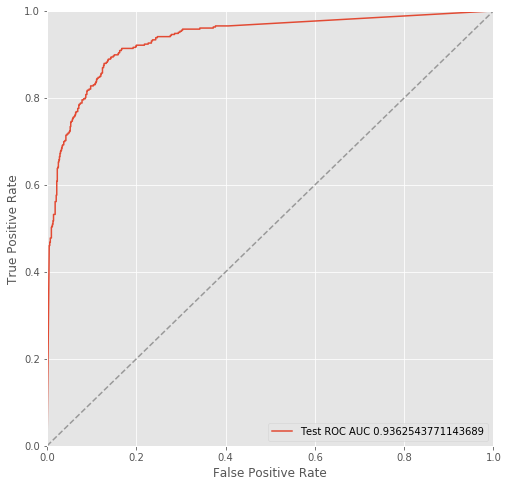

In [104]:
# Для knn
roc_auc_pic(p_pred_knn, y_test)

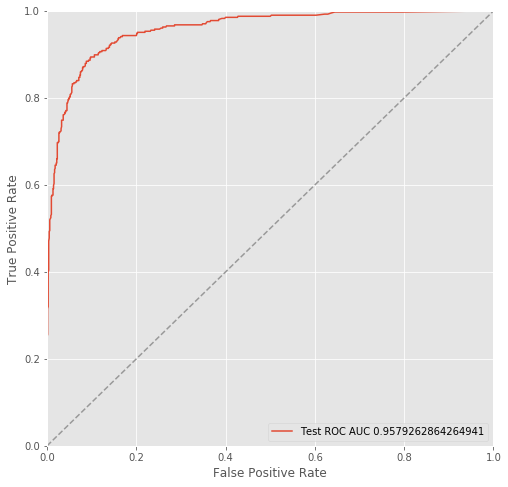

In [105]:
# Для леса
roc_auc_pic(p_pred_forest, y_test)

__Какая из моделей показывает более высокое качество по метрике roc_auc?__ 

Теперь сравним модели по площади под precision-recall кривой.

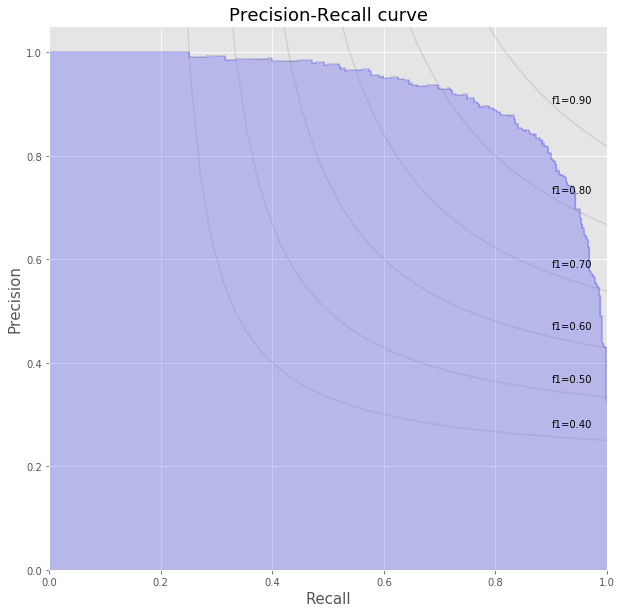

In [107]:
plot_precision_recall_curve(p_pred_forest, y_test)

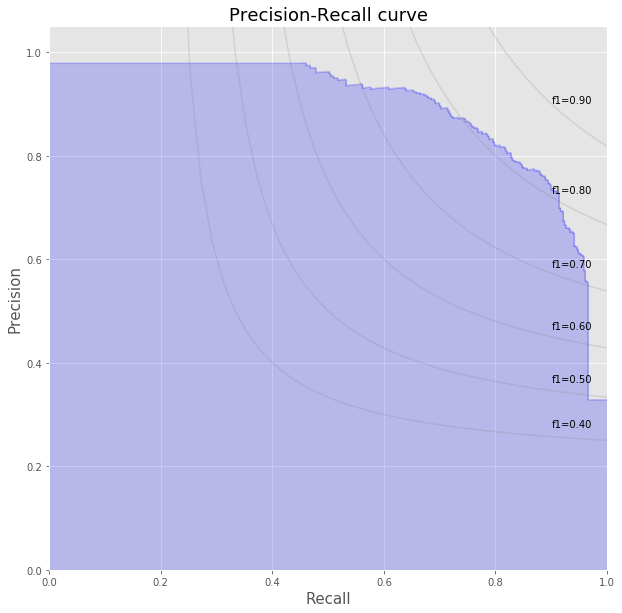

In [108]:
plot_precision_recall_curve(p_pred_knn, y_test)

__Вниманеи, вопрос!__ Что я сделал не так и почему так получилось?

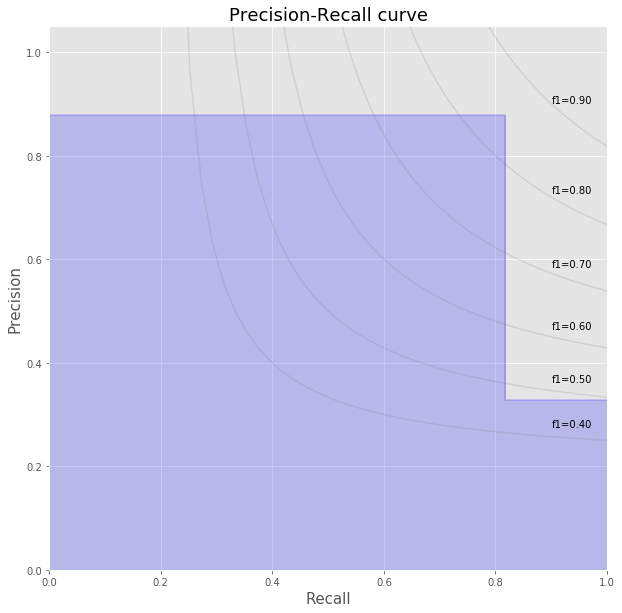

In [109]:
plot_precision_recall_curve(y_pred_forest, y_test)

In [111]:
accuracy_score(y_test, y_pred_forest)

0.9029126213592233

In [117]:
p = [0.5, 0.7, 0.8, 0.9, 0.4]
y = [ 1, 0, 1, 1, 0]

roc_auc_score(y, p)

0.8333333333333333

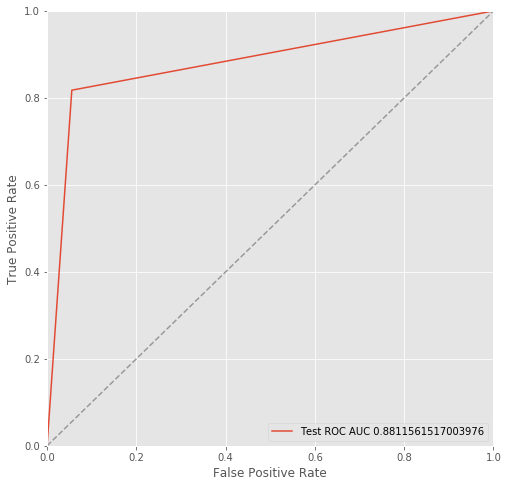

In [110]:
roc_auc_pic(y_pred_forest, y_test)

# 5. Feature Engineering (если есть время) 

В реальной жизни очевидных признаков всегда не хватает. Тогда приходится самостоятельно придумывать и извлекать новые признаки из сырых данных. Попробуем что-то придумать.

Первое, на что можно обратить внимание - это столбец `categoryId`. В нём находится числовой идентификатор категории. Попробуем для начала преобразовать его используя OHE.

In [34]:
from sklearn.preprocessing import OneHotEncoder

catEncoder = OneHotEncoder()
catEncoder.fit(train.categoryId.values.reshape((len(train), 1)))
cat_train = catEncoder.transform(train.categoryId.values.reshape((len(train), 1))).toarray()
cat_test = catEncoder.transform(test.categoryId.values.reshape((len(test), 1))).toarray()

/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


Кроме того, мы можем использовать наиболее часто употребляемые теги:

In [35]:
from ast import literal_eval

#для начала уберем пустые значения
train.tags = train.tags.apply(lambda tags: [] if pd.isnull(tags) else literal_eval(tags))
test.tags = test.tags.apply(lambda tags: [] if pd.isnull(tags) else literal_eval(tags))

/Users/maratakhm/Library/Python/3.7/lib/python/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [36]:
from collections import defaultdict
import operator

tags_frequency = defaultdict(int)
for tags in train.tags:
    for tag in tags:
        tags_frequency[tag.lower()] += 1
tags_frequency = sorted(tags_frequency.items(), key=operator.itemgetter(1),reverse=True)

Возьмём 50 наиболее популярных тэгов и бинаризуем их. 

In [37]:
tag_index = {tag[0]: index for index, tag in enumerate(tags_frequency[:50])}

In [38]:
def tagsToFeatures(tags):
    features = np.zeros(51)
    for tag in tags:
        index = tag_index.get(tag.lower(), -1)
        features[index] = 1
    return features[:50] 

In [39]:
tags_train = train.tags.apply(tagsToFeatures)
tags_train = np.array(tags_train.to_list())
tags_test = test.tags.apply(tagsToFeatures)
tags_test = np.array(tags_test.to_list())

Теперь обучим новый лес

In [40]:
X_train = np.hstack((X_train.values, cat_train, tags_train))
X_test = np.hstack((X_test.values, cat_test, tags_test))

In [41]:
X_train.shape, X_test.shape

((4943, 77), (1236, 77))

In [42]:
forest = RandomForestClassifier(max_depth=13, n_estimators=5000)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=13, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5000, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [43]:
y_predicted = forest.predict(X_test)
accuracy_score(y_test, y_predicted)

0.9409385113268608

Попробуйте перебрать параметры и добиться более высокой точности для леса

# Что мы сделали? 

1. Посмотрели на данные, поняли что хотим прогнозировать 
2. Посмотрели есть ли в данных пропуски, обработали их (выбросили либо заполнили)
3. Проскалировали переменные 
4. Подготовили переменную для прогнозирования, посмотрели есть ли с ней проблемы 
5. Начали строить модели, смотрим насколько они хороши по метрикам 
6. Подбираем гиперпараметры для моделей и пытаемся улучшить их